In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Boston Housing Dataset

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the Black population proportion by town
* LSTAT - \% lower status of the population
* MEDV - Median value of owner-occupied homes in \$1000's

In [148]:
df = pd.read_csv("housing.csv", header=None, sep='\s+')
df.columns = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", "medv"]
df = df[df["medv"] < 50]

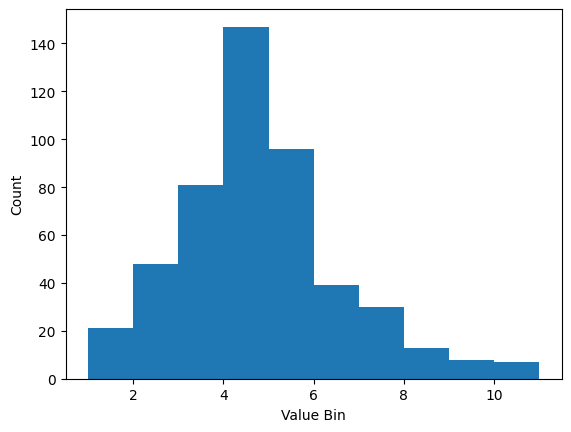

In [149]:
# The outcome variable is medv, the house price value. Let's discretize it into bins so that we can
# calculate entropy, etc.

num_bins = 10
outcome_bins = np.histogram_bin_edges(df["medv"], bins=num_bins)
discrete_outcomes = np.digitize(df["medv"], bins=outcome_bins)

# print (discrete_outcomes.min())
# print (discrete_outcomes.max())

plt.hist(discrete_outcomes)
plt.xlabel("Value Bin")
plt.ylabel("Count");

In [150]:
def discretize_data(df, spec):
    discrete_columns = {}
    for col, col_spec in spec.items():
        if col_spec["method"] == "keep":
            discrete_columns[col] = df[col].values
        elif col_spec["method"] == "bin":
            discrete_columns[col] = np.digitize(df[col], col_spec["bins"])
    return pd.DataFrame(discrete_columns, index=df.index)

discrete_df = discretize_data(df, {
    "crim": { "method": "bin", "bins": [np.mean(df["crim"])] },
    "zn": { "method": "bin", "bins": [1.0] },
    "indus": { "method": "bin", "bins": np.quantile(df["indus"], [0.25, 0.5, 0.75]) },
    "chas": { "method": "keep" },
    "nox": { "method": "bin", "bins": np.quantile(df["nox"], [0.25, 0.5, 0.75]) },
    "rm": { "method": "bin", "bins": np.quantile(df["rm"], [0.25, 0.5, 0.75]) },
    "age": { "method": "bin", "bins": np.quantile(df["age"], [0.25, 0.5, 0.75]) },
    "dis": { "method": "bin", "bins": np.quantile(df["dis"], [0.25, 0.5, 0.75]) },
    "rad": { "method": "bin", "bins": np.quantile(df["rad"], [0.25, 0.5, 0.75]) },
    "tax": { "method": "bin", "bins": np.quantile(df["tax"], [0.25, 0.5, 0.75]) },
    "ptratio": { "method": "bin", "bins": np.quantile(df["ptratio"], [0.25, 0.5, 0.75]) },
    "black": { "method": "bin", "bins": np.quantile(df["black"], [0.25, 0.5, 0.75]) },
    "lstat": { "method": "bin", "bins": np.quantile(df["lstat"], [0.25, 0.5, 0.75]) },
})

In [151]:
def calc_entropy(inputs):
    """
    Calculates the Shannon entropy of the given inputs, where inputs is an
    array or series of discrete values.
    """
    unique, counts = np.unique(inputs, return_counts=True)
    return -np.sum((counts / len(inputs)) * np.log2(counts / len(inputs)))
    
def entropy_difference(outcomes, mask):
    """
    Calculates a score that is higher when the distribution of outcomes 
    inside the given mask has a LOWER entropy than the distribution
    overall.
    
    Args:
        outcomes: A 1D or 2D array of discrete outcome values.
        mask: A 1D boolean array indicating whether each row
            is part of the slice being evaluated or not.
    """
    if len(outcomes.shape) > 1:
        return sum([calc_entropy(outcomes[:,i]) / calc_entropy(outcomes[mask,i])
                    for i in range(outcomes.shape[1])]) / outcomes.shape[1]
    else:
        if (calc_entropy(outcomes[mask]) > 0 ):
            return calc_entropy(outcomes) / calc_entropy(outcomes[mask])
        else :
            return 0

def mean_difference_l1(outcomes, mask):
    """
    Calculates a score that is higher when there is a larger difference
    between the average outcomes inside the given mask and the overall
    dataset, normalized by the population standard deviation.
    
    Args:
        outcomes: A 1D or 2D array of discrete (but ordered) outcome
            values.
        mask: A 1D boolean array indicating whether each row
            is part of the slice being evaluated or not.
    """
    if len(outcomes.shape) > 1:
        return np.abs(np.mean((outcomes[mask].mean(axis=0) - outcomes.mean(axis=0)) / outcomes.std(axis=0)))
    else:
        return (outcomes[mask].mean() - outcomes.mean()) / outcomes.std()
    
def group_size(outcomes, mask):
    return np.log2(1 + mask.sum() / len(mask))

27 examples in slice
Entropy score: 1.066727205923479
Difference score: 1.1916646422283717
Group size score: 0.07738253131236406


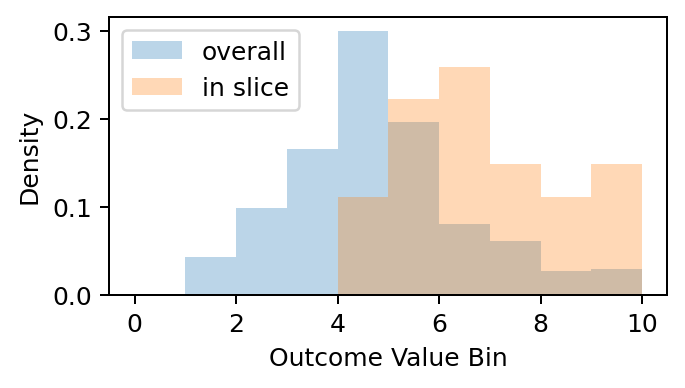

In [152]:
# A slice is defined by a set of pairs of columns and the values they take: [(col name, value)...]
# For instance, here we select a slice where all instances have the "indus" field with value 0
# and the "dis" field with value 2.
example_slice = (discrete_df["indus"] == 0) & (discrete_df["dis"] == 2)
print(example_slice.sum(), "examples in slice")

print("Entropy score:", entropy_difference(discrete_outcomes, example_slice))
print("Difference score:", mean_difference_l1(discrete_outcomes, example_slice))
print("Group size score:", group_size(discrete_outcomes, example_slice))

# Plot the difference in outcomes using a histogram
plt.figure(figsize=(4, 2), dpi=180)
plt.hist(discrete_outcomes, bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='overall')
plt.hist(discrete_outcomes[example_slice], bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='in slice')
plt.xlabel("Outcome Value Bin")
plt.ylabel("Density")
plt.legend()
plt.show()

In [153]:
# Implement a function that brute-force searches all possible slices of at most M features,
# and returns the top K slices
import itertools

# Class to hold data about a particular slice which includes it's score, features and values for the features.
class Slice:
    def __init__(self, score, features, values):
        self.score = score
        self.features = features
        self.values = values
        
    def __lt__(self, other):
        return self.score < other.score

def add_to_top_k_list(top_k_list, k, item):
    if (len(top_k_list) < k):
        top_k_list.append(item)
    else:
        min_index = top_k_list.index(min(top_k_list))
        if (top_k_list[min_index].score < item.score):
            top_k_list[min_index] = item


# function to assign values and generate combinations for selected features of a slice
def generate_values_for_feature_set(discrete_df, features):
    n = len(features)
    ranges = []
    for feature in features:
        ranges.append(range(discrete_df[feature].max()))

    # using itertools to generate all unique combinations of n features
    combinations = list(itertools.product(*ranges))
    return combinations

# calculate scores for slices and store it in a list
def calculate_scores (discrete_df, discrete_outcomes, features, combinations, K, top_k_slices):
#     print (features)
#     print (combinations)
    features_count = len(features)
    current_slice = []

    # here a combination is set of discrete values for a particular feature set
    for combination in combinations:
        for index in range(len(features)):
            if (index == 0):
                current_slice = discrete_df[features[index]] == combination[index]
            else :
                current_slice = current_slice & (discrete_df[features[index]] == combination[index])

        if (current_slice.sum() > 0):
            score = entropy_difference(discrete_outcomes, current_slice) + mean_difference_l1(discrete_outcomes, current_slice) + group_size(discrete_outcomes, current_slice) 
            new_slice = Slice(score, features, combination)
            add_to_top_k_list(top_k_slices, K, new_slice)
    
# function to generate all feature combinations of size m
def generate_feature_combinations(features, M):
    for feature_set in itertools.combinations(features, M):
        yield feature_set
        
# function to populate top_k_slices with data considering at the most M features
def populate_slices(discrete_df, discrete_outcomes, M, K, top_k_slices):
#     print (discrete_df.columns)
    print ("Slice finding for", M, "feature(s)")
    for value in generate_feature_combinations(discrete_df.columns, M):
        combinations = generate_values_for_feature_set(discrete_df, value)
        calculate_scores(discrete_df, discrete_outcomes, value, combinations, K, top_k_slices)
    print ("Done for: ", M)

In [154]:
def find_slices(discrete_df, discrete_outcomes, M, K):
    # set value for M: maximum number of features to include
    M = 4

    # set the value of K: number of top slices to find
    K = 10

    # list to store objects of Slice type
    top_k_slices = []

    # populate slices from size 1 to M
    for index in range(1, M + 1):
        populate_slices(discrete_df, discrete_outcomes, index, K, top_k_slices)

    top_k_slices.sort(key=lambda x: x.score, reverse=True)
        
    return top_k_slices

top_k_slices = find_slices(discrete_df, discrete_outcomes, M, K)

for a_slice in top_k_slices:
    print(a_slice.score, a_slice.features, a_slice.values)

Slice finding for 1 feature(s)
Done for:  1
Slice finding for 2 feature(s)
Done for:  2
Slice finding for 3 feature(s)
Done for:  3
Slice finding for 4 feature(s)
Done for:  4
7.834519016039068 ('indus', 'nox', 'lstat') (1, 1, 2)
7.834519016039068 ('crim', 'indus', 'nox', 'lstat') (0, 1, 1, 2)
7.452333677784524 ('indus', 'chas', 'nox', 'lstat') (1, 0, 1, 2)
7.06626149322504 ('indus', 'nox', 'rad', 'lstat') (1, 1, 2, 2)
6.676074450229697 ('crim', 'indus', 'rad', 'tax') (0, 1, 2, 0)
6.676074450229697 ('indus', 'chas', 'rad', 'tax') (1, 0, 2, 0)
6.676074450229697 ('indus', 'nox', 'rad', 'tax') (1, 1, 2, 0)
6.676074450229697 ('zn', 'nox', 'rad', 'tax') (0, 1, 2, 0)
6.676074450229697 ('indus', 'rad', 'tax') (1, 2, 0)
6.676074450229697 ('zn', 'indus', 'rad', 'tax') (0, 1, 2, 0)


15 examples in slice
Score:  7.834519016039068
Entropy score: 7.933455899133602
Difference score: -0.14243852173112032
Group size score: 0.04350163863658642

('indus', 'nox', 'lstat')
(1, 1, 2)

Following is graph for slice with highest overall score:


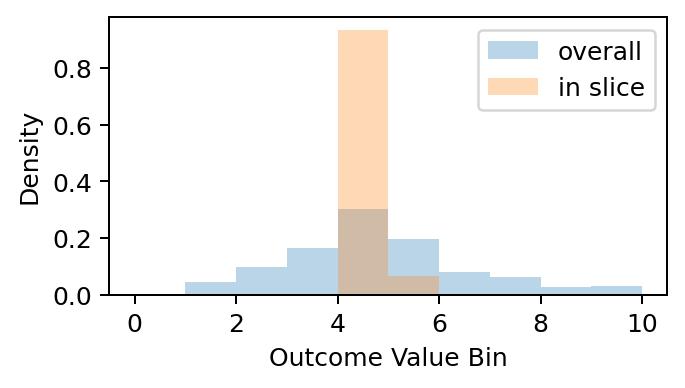

In [155]:
max_score_slice = []

combination = top_k_slices[0].values
features = top_k_slices[0].features

# here a combination is set of discrete values for a particular feature set
for index in range(len(features)):
    if (index == 0):
        max_score_slice = discrete_df[features[index]] == combination[index]
    else :
        max_score_slice = max_score_slice & (discrete_df[features[index]] == combination[index])
        
print(max_score_slice.sum(), "examples in slice")

if (max_score_slice.sum() > 0):
    score = entropy_difference(discrete_outcomes, max_score_slice) + mean_difference_l1(discrete_outcomes, max_score_slice) + group_size(discrete_outcomes, max_score_slice) 
    print ("Score: ", score)

print("Entropy score:", entropy_difference(discrete_outcomes, max_score_slice))
print("Difference score:", mean_difference_l1(discrete_outcomes, max_score_slice))
print("Group size score:", group_size(discrete_outcomes, max_score_slice))

print ("")
print (features)
print (combination)

print ("")
print ("Following is graph for slice with highest overall score:")
# Plot the difference in outcomes using a histogram
plt.figure(figsize=(4, 2), dpi=180)
plt.hist(discrete_outcomes, bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='overall')
plt.hist(discrete_outcomes[max_score_slice], bins=np.arange(num_bins + 1), alpha=0.3, density=True, label='in slice')
plt.xlabel("Outcome Value Bin")
plt.ylabel("Density")
plt.legend()
plt.show()
